In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix , classification_report
import warnings
warnings.filterwarnings('ignore')

In [168]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [169]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [170]:
def drop(df):
    df = df.copy()
    df = df.drop(['keyword', 'location'], axis = 1)
    return df

In [171]:
train_df = drop(train_df)
test_df = drop(test_df)

In [172]:
train_df.isna().sum()

id        0
text      0
target    0
dtype: int64

In [173]:
test_df.isna().sum()

id      0
text    0
dtype: int64

In [174]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [175]:
test_df.shape

(3263, 2)

# Function to convert text into sequences

In [176]:
def get_sequences(texts, tokenizer, train = True, max_seq_len = None):
    sequence = tokenizer.texts_to_sequences(texts)
    if train == True:
        max_seq_len = np.max(list(map(len, sequence)))
    sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen = max_seq_len, padding = 'post')
    return sequence

In [177]:
def pre_processing(df):
    df = df.copy()
    X = df['text']
    Y = df['target']
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.30, shuffle = True, random_state = 1)
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(x_train)
    print(f'Vocab Length : {len(tokenizer.word_index)+1}')
    x_train = get_sequences(texts = x_train, tokenizer = tokenizer, train = True)
    x_test = get_sequences(texts = x_test, tokenizer = tokenizer, train = False, max_seq_len = x_train.shape[1])
    print(f'\nSequence Length : {x_train.shape[1]}')
    return x_train, x_test, y_train, y_test

In [178]:
x_train, x_test, y_train, y_test = pre_processing(train_df)

Vocab Length : 17707

Sequence Length : 32


# Training

In [179]:
inputs = tf.keras.Input(shape = (32, ))
x = tf.keras.layers.Embedding(input_dim = 17707, output_dim = 100)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')]
)
print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 32, 100)           1770700   
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               409728    
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 2,197,069
Trainable params: 2,197,069
Non-trainable params: 0
_________________________________________________

In [180]:
history = model.fit(
    x_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True
        )
    ],
    class_weight = {
        0 : 1,
        1 : 3
    }
)

Epoch 1/100
134/134 [==============================] - 4s 20ms/step - loss: 0.9947 - accuracy: 0.5515 - auc: 0.7401 - val_loss: 0.5141 - val_accuracy: 0.7730 - val_auc: 0.8544
Epoch 2/100
134/134 [==============================] - 2s 18ms/step - loss: 0.3725 - accuracy: 0.9193 - auc: 0.9688 - val_loss: 0.7995 - val_accuracy: 0.6764 - val_auc: 0.8205
Epoch 3/100
134/134 [==============================] - 2s 17ms/step - loss: 0.1154 - accuracy: 0.9794 - auc: 0.9959 - val_loss: 0.7938 - val_accuracy: 0.6989 - val_auc: 0.8283
Epoch 4/100
134/134 [==============================] - 2s 18ms/step - loss: 0.0542 - accuracy: 0.9862 - auc: 0.9988 - val_loss: 0.6971 - val_accuracy: 0.7477 - val_auc: 0.8379
Epoch 5/100
134/134 [==============================] - 3s 21ms/step - loss: 0.0334 - accuracy: 0.9904 - auc: 0.9994 - val_loss: 0.7092 - val_accuracy: 0.7758 - val_auc: 0.8399
Epoch 6/100
134/134 [==============================] - 2s 17ms/step - loss: 0.0258 - accuracy: 0.9918 - auc: 0.9997 - va

# Results

In [181]:
results = model.evaluate(x_test, y_test, verbose = 0)
print(f'Accuracy : {round(results[1]*100, 4)}%')
print(f'AUC : {round(results[2],3)}')

Accuracy : 77.3643%
AUC : 0.839


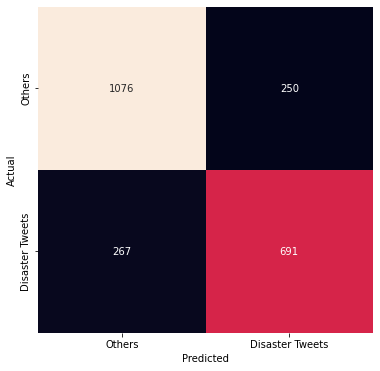

Classification Report ------------------->
                 precision    recall  f1-score   support

         Others       0.80      0.81      0.81      1326
Disaster Tweets       0.73      0.72      0.73       958

       accuracy                           0.77      2284
      macro avg       0.77      0.77      0.77      2284
   weighted avg       0.77      0.77      0.77      2284



In [182]:
y_pred = np.squeeze(model.predict(x_test) >= 0.5).astype(np.int)
cm = confusion_matrix(y_test, y_pred,labels = [0,1] )
clr = classification_report(y_test, y_pred, labels = [0,1], target_names = ['Others', "Disaster Tweets"])
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False)
plt.xticks(ticks = [0.5, 1.5], labels = ['Others', "Disaster Tweets"])
plt.yticks(ticks = [0.5, 1.5], labels = ['Others', "Disaster Tweets"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'Classification Report ------------------->\n{clr}')

In [183]:
test_df_text = test_df['text']

In [184]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(test_df_text)
print(f'Vocab Length : {len(tokenizer.word_index)+1}')
test_df_text = get_sequences(texts = test_df_text, tokenizer = tokenizer, train = False, max_seq_len = x_train.shape[1])
print(f'\nSequence Length : {test_df_text.shape[1]}')

Vocab Length : 12819

Sequence Length : 32


In [185]:
f_pred = np.squeeze(model.predict(test_df_text) >= 0.5).astype(np.int)

In [188]:
submission = test_df[['id']]
submission['target'] = f_pred
submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,1


In [189]:
submission.to_csv('submission.csv', index=False)